In [1]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import snow depth and all radar freeboard data from 01/10/2019 - 31/03/2020
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])[3560:3773]
cs2_cpom = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'][3560:3773])
cs2_larm = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_LARM_full.nc')['Radar Freeboard'][3560:3773])
cs2s3_cpom = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_CPOM_full.nc')['Radar Freeboard'][3560:3773])
cs2s3_larm = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_LARM_full.nc')['Radar Freeboard'][3560:3773])

days = np.arange(0,len(snow))

### calculate regional and pan-arctic anomalies for every satellite

In [3]:
sats = ['SM-LG','CS2_CPOM','CS2_LARM','CS2S3_CPOM','CS2S3_LARM']

# function to calculate regional means 
def regions_WG(regs):
    WG_mean = []
    WG_c = all_interps.copy()
    for day in days:
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in days:
        WG_mean.append(np.nanmean(WG_c[day]))
    return(WG_mean)

# function to calculate running mean, where T = np.int(number of days/2)
def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T]))

    for i in range(np.size(means)-T,np.size(means)):
        r.append(np.nanmean(means[i-T:]))

    return r

In [4]:
### regional anomalies
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

T = 15 # 31-day running mean

snow_anoms = {} ; cs2_cpom_anoms = {} ; cs2_larm_anoms = {} ; cs2s3_cpom_anoms = {} ; cs2s3_larm_anoms = {}
lists = [snow_anoms,cs2_cpom_anoms,cs2_larm_anoms,cs2s3_cpom_anoms,cs2s3_larm_anoms]
data = [snow,cs2_cpom,cs2_larm,cs2s3_cpom,cs2s3_larm]

for count,l in enumerate(lists):
    all_interps = data[count]
    for region, reg in zip(regions, regs):
        dm = regions_WG(reg)
        rm = runningmean(dm,T=15)
        l[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))

### calculate regional monthly correlation for every satellite

In [5]:
days = [np.arange(0,31), # Oct
        np.arange(31,61), # Nov
        np.arange(61,91), # Dec
        np.arange(91,122), # Jan
        np.arange(122,151), # Feb
        np.arange(151,182), # Mar
        np.arange(182,212) #Apr
       ]

def stats():
    fb = l[region][day]
    snow = snow_anoms[region][day]
    mask = ~np.isnan(fb) & ~np.isnan(snow) 
    try:
        rstats = pearsonr(snow[mask],fb[mask])
        r = np.round(rstats[0],decimals=2)
        return(r)
    except:
        r = np.nan

In [6]:
### regional stats
cs2_cpom_c = {} ; cs2_larm_c = {} ; cs2s3_cpom_c = {} ; cs2s3_larm_c = {}
corrs = [cs2_cpom_c,cs2_larm_c,cs2s3_cpom_c,cs2s3_larm_c]

for l,c in zip(lists[1:],corrs):
    
    for region in regions:
        monthly_stats = []
        for day in days:
            r = stats()
            monthly_stats.append(r)
        c[region]=monthly_stats 

### plot figure

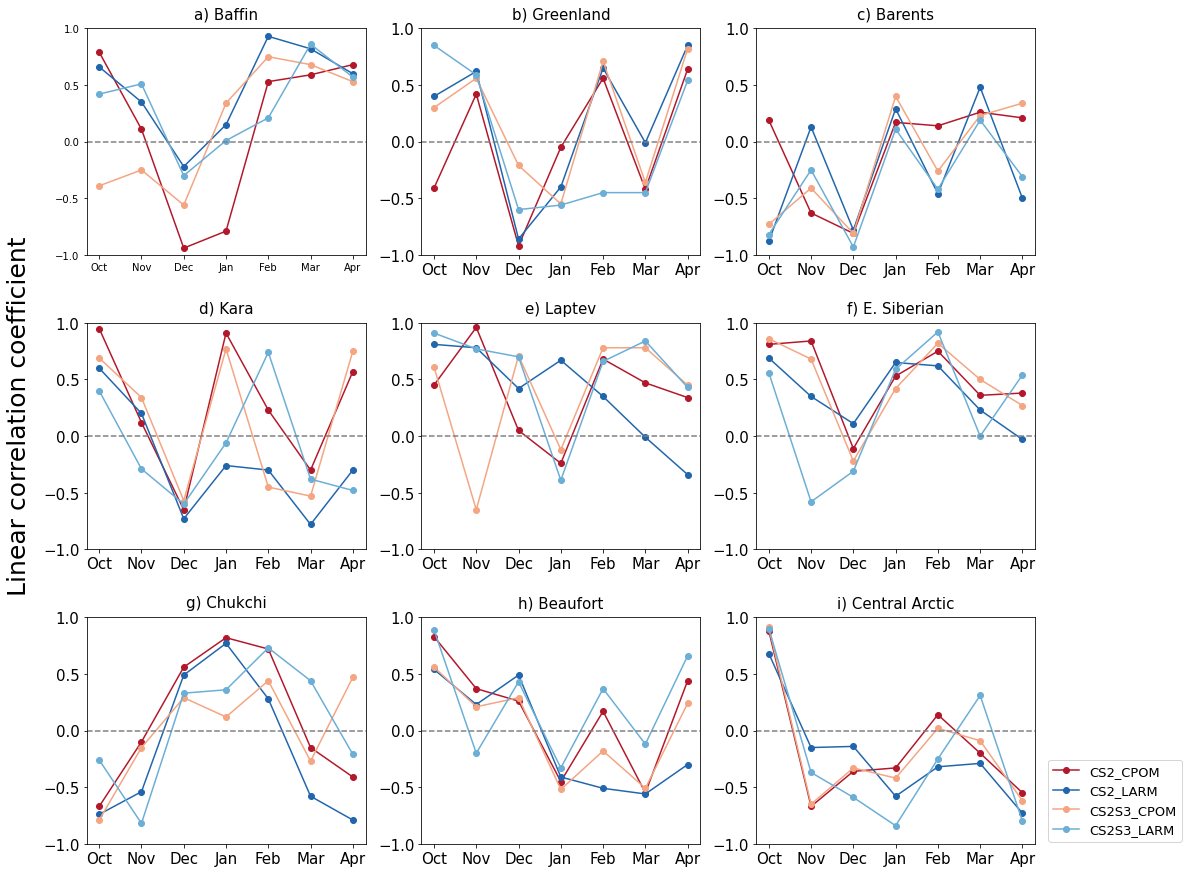

In [7]:
fig = plt.figure(figsize=(17,15))
spec = gridspec.GridSpec(ncols=3, nrows=3, wspace=0.2,hspace=0.3)

colors = ['#b2182b','#2166ac','#f4a582','#6baed6']
months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr']
nums = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ', 'f) ', 'g) ', 'h) ', 'i) ', 'j) ']

for count in np.arange(0,9):
    region = regions[count]
    ax = fig.add_subplot(spec[count])
    ax.set_title(nums[count]+region,pad=10,fontsize=15)
    for dic,sat,color in zip(corrs,sats[1:],colors):
        ax.plot(months,dic[region],label = sat,color=color,marker="o")
    ax.axhline(0,linestyle='dashed',color='grey')
    ax.set_ylim([-1,1])
    ax.set_yticks([-1,-0.5,0,0.5,1])
    plt.rc('font', size=15)
    
    if count ==8:      
        ax.legend(bbox_to_anchor = (1.55, 0.4),fontsize=13)
fig.text(0.07, 0.36, 'Linear correlation coefficient', ha='center',fontsize=25,rotation='vertical')
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/seasonal_correlations.png',bbox_inches = "tight", dpi = 400)